# National-level analysis: Figures 1 & 4

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.integrate as integrate
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['pdf.fonttype'] = 42

## Figure 1

In [2]:
# Get both ensembles
from combine import combine_nex_yield, combine_cmip_yield
nex_hist = combine_nex_yield()
cmip_hist = combine_cmip_yield()

In [3]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../usda/output/USDA_county_yields_w_county_quad_trends.csv').filter(["GEOID", "year", "area","yield"])
weights["GEOID"] = weights["GEOID"].astype(str).str.zfill(5)
weights.sort_values(by = ['GEOID', 'year'], inplace = True)
weights.set_index(['GEOID', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])

In [4]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [5]:
##################################################################################################
include_p05 = False ################# If True, only counties with F-test p-value < 0.05 are included
include_loo = True ################# If True, only counties with LOO CV improvement are included
if include_p05:
    p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
elif include_loo:
    p05_counties = pd.read_csv('../ag_model/fit_model/loo_yes.csv')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
##################################################################################################

# Yield (weighted by production)
nex_weighted = pd.merge(nex_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['Year']).sum()

cmip_weighted = pd.merge(cmip_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['Year']).sum()

# # Ensembles
# NEXens_w = nex_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
# CMIPens_w = cmip_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
# GMFDens_w = nex_weighted.filter(['GMFD']).to_numpy().flatten()

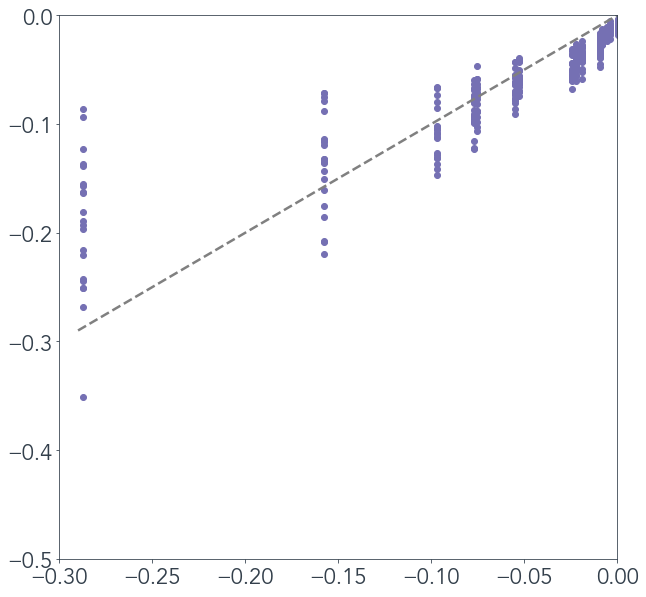

In [85]:
fig, ax = plt.subplots(figsize=(10,10))

for model in cmip_weighted.columns[:-2]:
#     ax.scatter(np.sort(cmip_weighted['GMFD']),np.sort(cmip_weighted[model]), color = '#d95f02')
    ax.scatter(np.sort(nex_weighted['GMFD']),np.sort(nex_weighted[model]), color = '#7570b3')

spacing = np.linspace(-0.29,0.1,100)
ax.plot(spacing, spacing, ls='--', color='gray', lw=2.5)
ax.set_xlim([-0.3,0])
ax.set_ylim([-0.5,0])
plt.show()

In [114]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

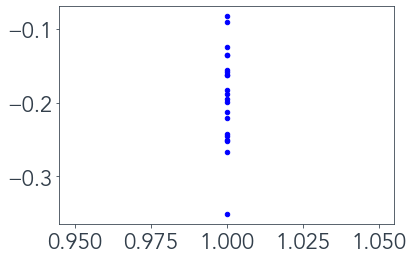

In [115]:
jitter([1]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).min(axis=0))

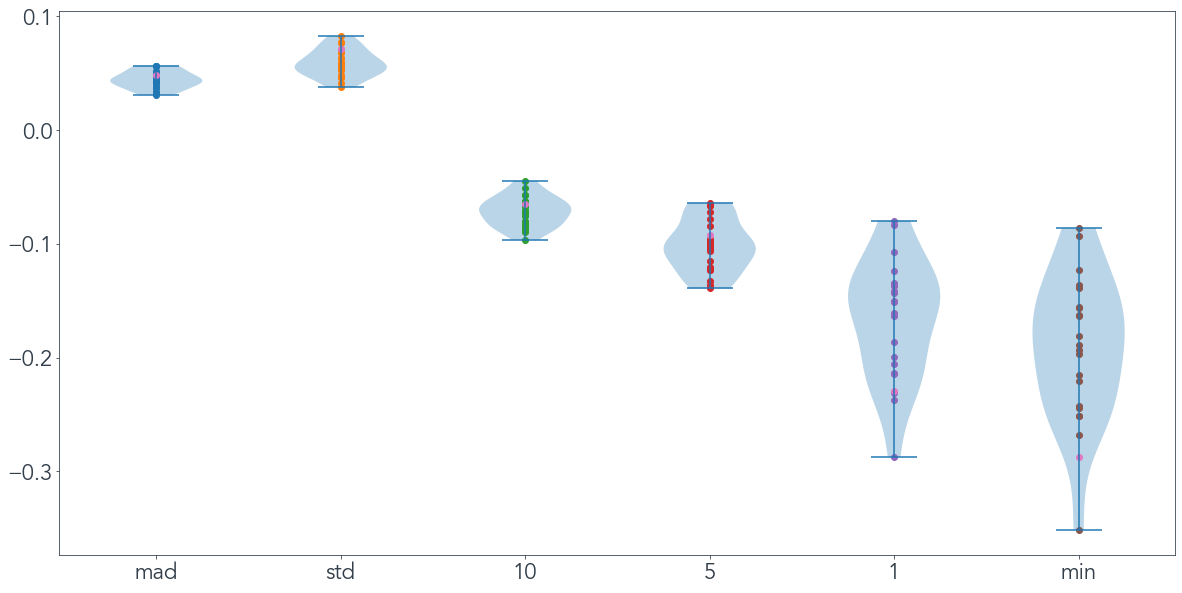

In [119]:
fig, ax = plt.subplots(figsize=(20,10))

ax.violinplot([nex_weighted.drop(columns=['national_weight','GMFD']).mad(axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).std(axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.1, axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.05, axis=0),
            nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.01, axis=0),
           nex_weighted.drop(columns=['national_weight', 'GMFD']).min(axis=0)])


ax.scatter([1]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).mad(axis=0))
ax.scatter([2]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).std(axis=0))
ax.scatter([3]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.1, axis=0))
ax.scatter([4]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.05, axis=0))
ax.scatter([5]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).quantile(q=0.01, axis=0))
ax.scatter([6]*21, nex_weighted.drop(columns=['national_weight', 'GMFD']).min(axis=0))

ax.scatter([1,2,3,4,5,6],
       [nex_weighted['GMFD'].mad(),
       nex_weighted['GMFD'].std(),
       nex_weighted['GMFD'].quantile(q=0.1),
       nex_weighted['GMFD'].quantile(q=0.05),
       nex_weighted['GMFD'].quantile(q=0.01),
       nex_weighted['GMFD'].min()])

ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(labels=['mad','std','10','5','1','min'])
plt.show()

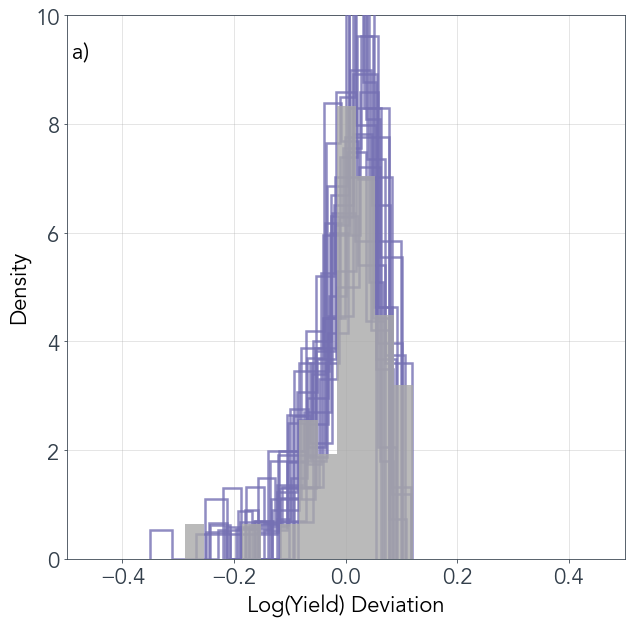

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams['font.size'] = 22

# PDF
# cmip_weighted.drop(columns = ['national_weight', 'GMFD']).plot(kind='hist', legend=None, histtype='step', bins='fd', label = 'CMIP', color = '#d95f02', linewidth=2.5, density=True, ax=ax, alpha=0.6, zorder=10)
nex_weighted.drop(columns = ['national_weight', 'GMFD']).plot(kind='hist', legend=None, histtype='step', bins='fd', label = 'NEX-GDDP', color = '#7570b3', linewidth=2.5, density=True, ax=ax, alpha=0.8, zorder=10)
ax.hist(GMFDens_w, label = 'Obs.', color = 'darkgray', density=True, bins='fd', zorder=20, alpha=0.8)

ax.set_xlabel('Log(Yield) Deviation')
ax.set_ylabel('Density')
ax.text(0.01, 0.92, 'a)', transform=ax.transAxes)
ax.grid(zorder=10, alpha=0.4)
ax.set_ylim([0,10])
ax.set_xlim([-0.5,0.5])

plt.show()

In [18]:
%%time
# Construct CDFs
nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_w), 3*silverman(NEXens_w), 30)})
cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_w), 3*silverman(CMIPens_w), 30)})
nexgrid.fit(NEXens_w[:, None])
cmipgrid.fit(CMIPens_w[:, None])
print(nexgrid.best_params_['bandwidth'])
print(cmipgrid.best_params_['bandwidth'])
NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth'])
NEX_ens_pdf.fit(NEXens_w[:, np.newaxis]);
CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth'])
CMIP_ens_pdf.fit(CMIPens_w[:, np.newaxis]);

0.01909519300964212
0.03568534176614341
CPU times: user 2.3 s, sys: 5.89 ms, total: 2.31 s
Wall time: 2.32 s


KernelDensity(bandwidth=0.03568534176614341)

In [19]:
%%time
sampDist = [NEX_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]
CsampDist = [CMIP_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]

CPU times: user 3.68 s, sys: 36.1 ms, total: 3.72 s
Wall time: 3.73 s


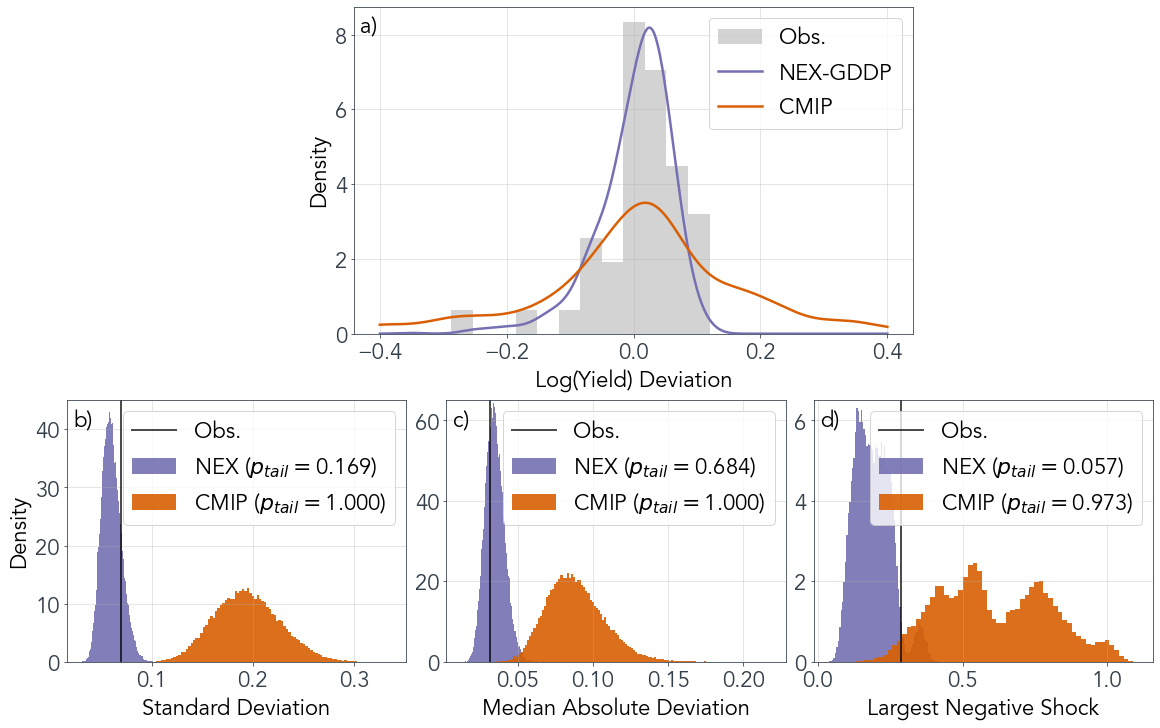

In [31]:
# Final
fig = plt.figure(figsize=(16,10), constrained_layout=True)
gs = gridspec.GridSpec(9, 9, figure=fig)
plt.rcParams['font.size'] = 22

# PDF
ax1 = fig.add_subplot(gs[:5,2:-2])
xarr = np.linspace(-0.4,0.4,1000)
ax1.hist(GMFDens_w, label = 'Obs.', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax1.plot(xarr, np.exp(NEX_ens_pdf.score_samples(xarr[:,None])), label = 'NEX-GDDP', color = '#7570b3', linewidth=2.5)
ax1.plot(xarr, np.exp(CMIP_ens_pdf.score_samples(xarr[:,None])), label = 'CMIP', color = '#d95f02', linewidth=2.5)

handles, labels = ax1.get_legend_handles_labels()
order = [2,0,1]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax1.set_xlabel('Log(Yield) Deviation')
ax1.set_ylabel('Density')
ax1.text(0.01, 0.92, 'a)', transform=ax1.transAxes)
ax1.grid(zorder=10, alpha=0.4)

# SD
ax2 = fig.add_subplot(gs[-4:, :3])
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax2.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax2.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax2.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax2.set_xlabel('Standard Deviation')
ax2.set_ylabel('Density')
ax2.text(0.02, 0.9, 'b)', transform=ax2.transAxes)
ax2.legend()
ax2.grid(zorder=10, alpha=0.4)
ax2.set_ylim([0,45])

# MAD
ax3 = fig.add_subplot(gs[-4:, 3:6])
sampDist1 = np.array([ss.median_abs_deviation(x) for x in sampDist])
CsampDist1 = np.array([ss.median_abs_deviation(x) for x in CsampDist])
val = ss.median_abs_deviation(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax3.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax3.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax3.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax3.set_xlabel('Median Absolute Deviation')
ax3.text(0.02, 0.9, 'c)', transform=ax3.transAxes)
ax3.legend()
ax3.grid(zorder=10, alpha=0.4)
ax3.set_ylim([0,65])

# Min
ax4 = fig.add_subplot(gs[-4:, 6:])
sampDist1 = np.array([np.abs(np.min(x)) for x in sampDist])
CsampDist1 = np.array([np.abs(np.min(x)) for x in CsampDist])
val = np.abs(np.min(GMFDens_w))
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax4.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax4.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax4.plot([val,val], [0,10], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax4.set_xlabel('Largest Negative Shock')
ax4.text(0.02, 0.9, 'd)', transform=ax4.transAxes)
ax4.legend()
ax4.set_xticks([0.0,0.5,1.0])
ax4.grid(zorder=0, alpha=0.4)
ax4.set_ylim([0,6.5])

# Save
# plt.show()
plt.savefig('../figs/figure1.pdf')

In [1]:
import numpy as np
import pandas as pd

In [23]:
nex = !ls ../../data/climate/NEX-GDDP

In [24]:
nex

['agvar_historical_r1i1p1_ACCESS1-0.csv',
 'agvar_historical_r1i1p1_BNU-ESM.csv',
 'agvar_historical_r1i1p1_CCSM4.csv',
 'agvar_historical_r1i1p1_CESM1-BGC.csv',
 'agvar_historical_r1i1p1_CNRM-CM5.csv',
 'agvar_historical_r1i1p1_CSIRO-Mk3-6-0.csv',
 'agvar_historical_r1i1p1_CanESM2.csv',
 'agvar_historical_r1i1p1_GFDL-CM3.csv',
 'agvar_historical_r1i1p1_GFDL-ESM2G.csv',
 'agvar_historical_r1i1p1_GFDL-ESM2M.csv',
 'agvar_historical_r1i1p1_IPSL-CM5A-LR.csv',
 'agvar_historical_r1i1p1_IPSL-CM5A-MR.csv',
 'agvar_historical_r1i1p1_MIROC-ESM-CHEM.csv',
 'agvar_historical_r1i1p1_MIROC-ESM.csv',
 'agvar_historical_r1i1p1_MIROC5.csv',
 'agvar_historical_r1i1p1_MPI-ESM-LR.csv',
 'agvar_historical_r1i1p1_MPI-ESM-MR.csv',
 'agvar_historical_r1i1p1_MRI-CGCM3.csv',
 'agvar_historical_r1i1p1_NorESM1-M.csv',
 'agvar_historical_r1i1p1_bcc-csm1-1.csv',
 'agvar_historical_r1i1p1_inmcm4.csv',
 'agvar_rcp85_r1i1p1_ACCESS1-0.csv',
 'agvar_rcp85_r1i1p1_BNU-ESM.csv',
 'agvar_rcp85_r1i1p1_CCSM4.csv',
 'agvar_r

In [25]:
temp = pd.read_csv('../../data/climate/NEX-GDDP/' + nex[0])
temp.rename(columns = {'GEOID':'fips', 'egdd':'edd', 'Year':'year'}, inplace=True)

In [26]:
temp['fips'] = temp['fips'].astype(str).str.zfill(5)
temp['state'] = temp['fips'].str[:2]

In [27]:
temp

,fips,year,gdd,edd,prcp,state
0,01001,1950,2109.770592,99.882512,0.624913,01
1,01001,1951,2079.099594,46.891599,1.235783,01
2,01001,1952,2208.289702,131.026777,0.756662,01
3,01001,1953,2173.759404,57.270075,0.739666,01
4,01001,1954,2236.753594,106.356311,0.769762,01
...,...,...,...,...,...,...
174435,56045,2001,1095.214214,41.051313,0.232291,56
174436,56045,2002,1282.518907,85.919061,0.196021,56
174437,56045,2003,1190.448175,69.711416,0.299054,56
174438,56045,2004,1144.948965,29.949336,0.269137,56


In [28]:
for name in nex:
    temp = pd.read_csv('../../data/climate/NEX-GDDP/' + name)
#     temp.rename(columns = {'GEOID':'fips', 'egdd':'edd', 'Year':'year'}, inplace=True)
    temp['fips'] = temp['fips'].astype(str).str.zfill(5)
    temp['state'] = temp['fips'].str[:2]
    temp.to_csv('../../data/climate/NEX-GDDP/' + name, index=False)